<a href="https://colab.research.google.com/github/jsysys/DRF_hw/blob/main/1_Garbage_Classification_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Garbage Classification

### 라이브러리 불러오기

- 수업에서 다룬 tensorflow.keras 모듈들을 불러옵니다.

- 사전 지식이 있는 학생이라면 기타 프레임워크(Pytorch)도 사용 가능합니다.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from PIL import Image
import pandas as pd

### 데이터 다운로드

- 아래의 코드로 데이터를 다운받습니다.


In [ ]:
#!pip install gdown

In [3]:
import zipfile
import gdown

file_id = '1gLKQe5Qxe8fC19r7QAfXmBtg_1zLDen6'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1gLKQe5Qxe8fC19r7QAfXmBtg_1zLDen6
From (redirected): https://drive.google.com/uc?id=1gLKQe5Qxe8fC19r7QAfXmBtg_1zLDen6&confirm=t&uuid=f005a4e0-30a4-4a7e-aa09-bd5d612a2982
To: /content/dataset.zip
100%|██████████| 52.5M/52.5M [00:00<00:00, 122MB/s]


'dataset.zip'

In [4]:
# 압축 해제
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

### EDA 및 데이터 특성 파악 및 시각화

- 다양한 방법을 사용해 데이터의 기본 정보, 특성, 분포 등을 파악하고 시각화해보세요.

In [5]:
# 데이터셋 경로 설정
train_dir = 'dataset/train'
test_dir = 'dataset/test'
train_categories = os.listdir(train_dir)
test_categories = os.listdir(test_dir)

# 데이터 개요 확인 함수
def dataset_overview(directory):
    categories = os.listdir(directory)  # 주어진 디렉토리의 카테고리 목록
    total_images = 0  # 전체 이미지 수를 저장할 변수
    class_counts = {}  # 각 카테고리별 이미지 수를 저장할 딕셔너리

    for category in categories:  # 각 카테고리에 대해
        category_path = os.path.join(directory, category)  # 카테고리의 경로
        num_images = len(os.listdir(category_path))  # 해당 카테고리의 이미지 수
        class_counts[category] = num_images  # 딕셔너리에 저장
        total_images += num_images

    return total_images, class_counts

# 훈련 데이터 개요
total_train_images, train_class_counts = dataset_overview(train_dir)
print(f"Total number of training images: {total_train_images}")  # 전체 훈련 이미지 수 출력
for category, count in train_class_counts.items():  # 각 카테고리별 이미지 수 출력
    print(f"Category: {category}, Number of training images: {count}")

# 테스트 데이터 개요
total_test_images, test_class_counts = dataset_overview(test_dir)
print(f"\nTotal number of testing images: {total_test_images}")  # 전체 테스트 이미지 수 출력
for category, count in test_class_counts.items():  # 각 카테고리별 이미지 수 출력
    print(f"Category: {category}, Number of testing images: {count}")

Total number of training images: 3720
Category: metal, Number of training images: 620
Category: paper, Number of training images: 620
Category: battery, Number of training images: 620
Category: organic, Number of training images: 620
Category: plastic, Number of training images: 620
Category: glass, Number of training images: 620

Total number of testing images: 930
Category: metal, Number of testing images: 155
Category: paper, Number of testing images: 155
Category: battery, Number of testing images: 155
Category: organic, Number of testing images: 155
Category: plastic, Number of testing images: 155
Category: glass, Number of testing images: 155


Training images:


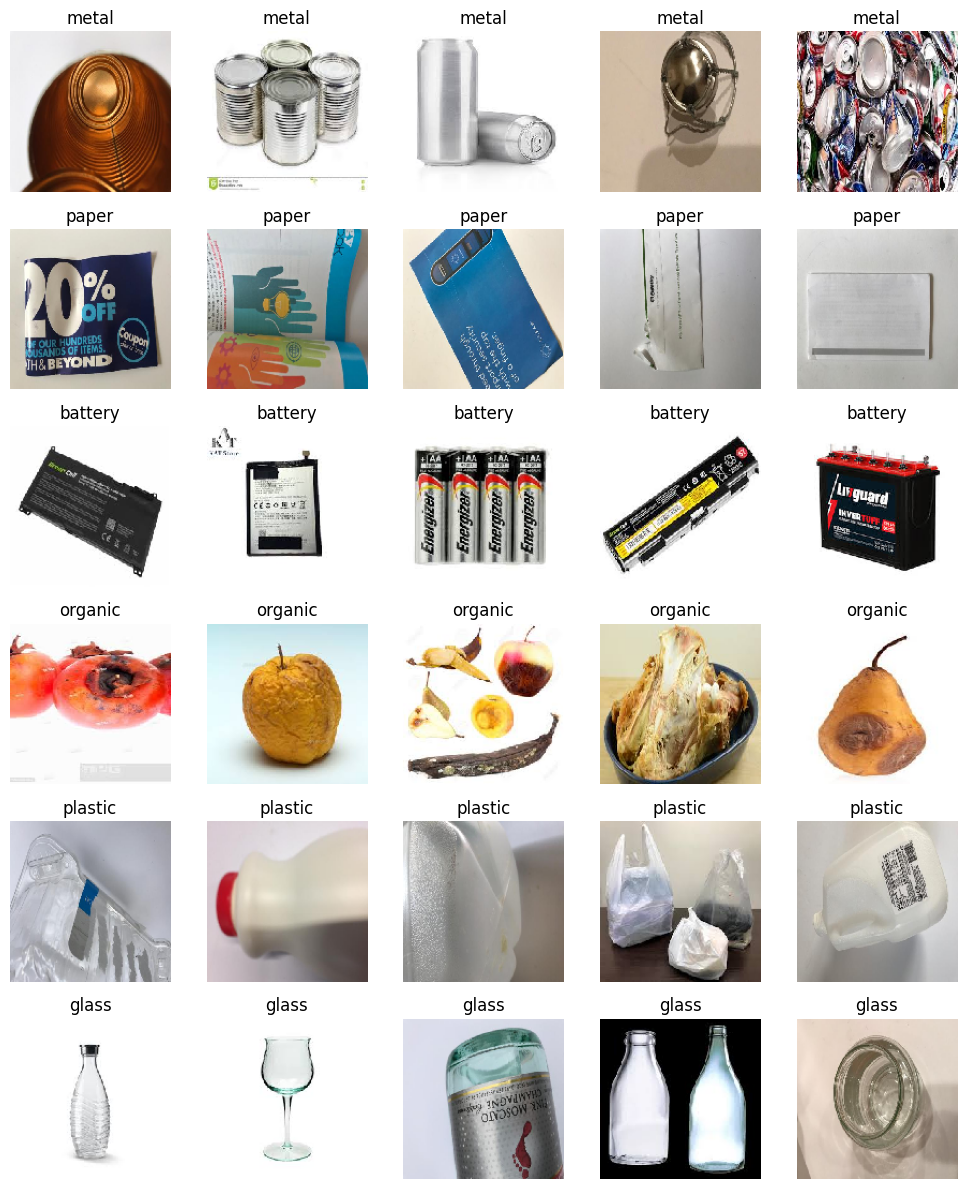

Testing images:


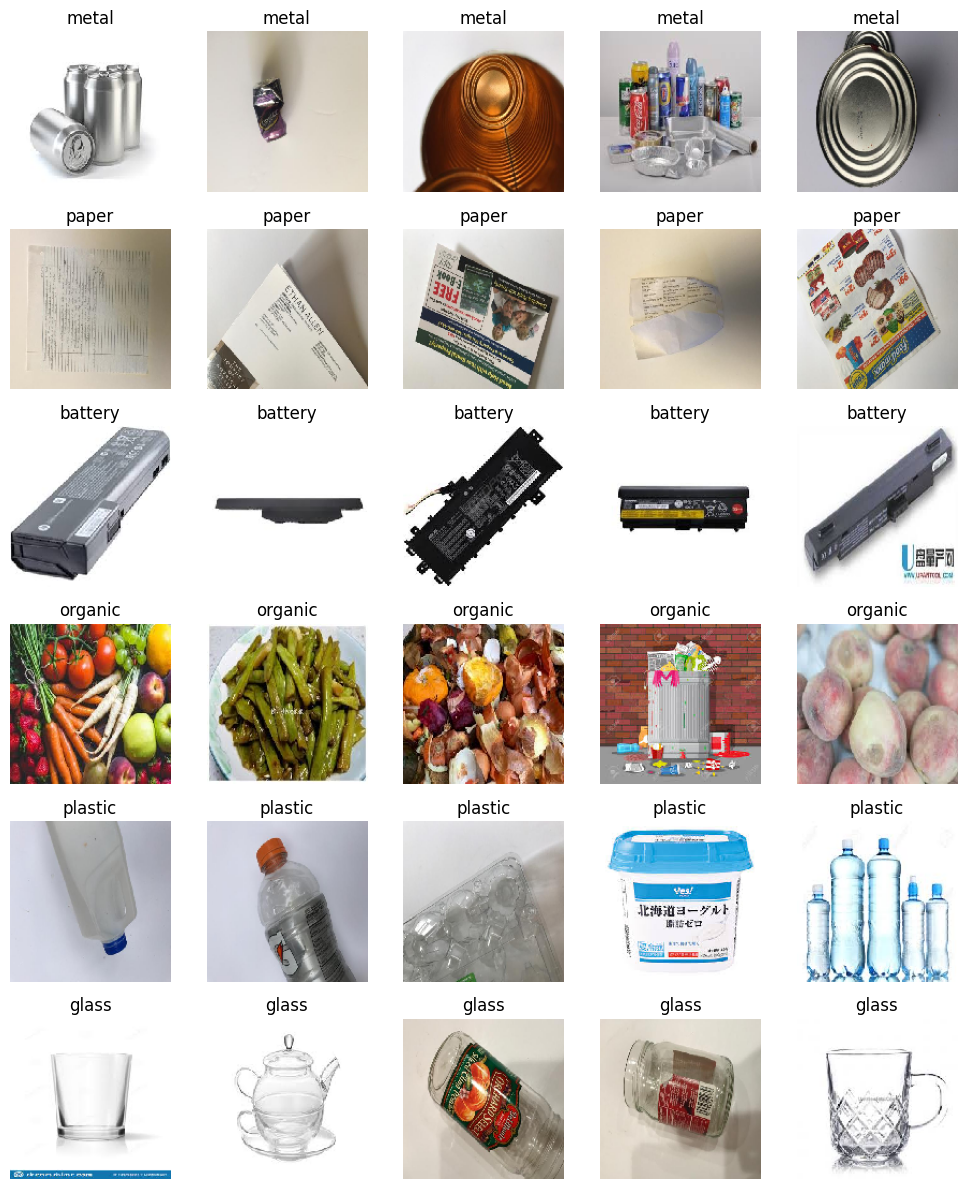

In [6]:
# 이미지 시각화 함수
def visualize_images(directory, categories, num_images=5):
    plt.figure(figsize=(10, 12))
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        images = [img for img in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, img))][:num_images]
        for j, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name) # 이미지 파일의 경로 설정
            img = image.load_img(img_path, target_size=(150, 150)) # 이미지를 불러와서 크기를 (150, 150)으로 조정
            plt.subplot(len(categories), num_images, i * num_images + j + 1) # 서브플롯 설정
            plt.imshow(img) # 이미지를 서브플롯에 표시
            plt.title(category) # 서브플롯의 제목을 카테고리명으로 설정
            plt.axis('off') # 축 표기 삭제
    plt.tight_layout() # 플롯 간격 자동 조정
    plt.show()

# 훈련 이미지 시각화
print("Training images:")
visualize_images(train_dir, train_categories)

# 테스트 이미지 시각화
print("Testing images:")
visualize_images(test_dir, test_categories)

In [7]:
from PIL import Image
from collections import Counter

# 이미지 크기 및 채널 분석 함수
def analyze_image_sizes(directory):
    image_sizes = []
    for category in os.listdir(directory):  # 디렉토리 내의 각 카테고리에 대해 반복
        category_path = os.path.join(directory, category) # 각 카테고리의 경로 설정
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            with Image.open(img_path) as img:
                image_sizes.append(img.size) # 이미지의 크기를 리스트에 추가
    return Counter(image_sizes) # 이미지 크기의 빈도를 계산하여 반환

# 훈련 데이터 이미지 크기 분석
train_image_sizes = analyze_image_sizes(train_dir)
print("Training image sizes:", train_image_sizes)

# 테스트 데이터 이미지 크기 분석
test_image_sizes = analyze_image_sizes(test_dir)
print("Testing image sizes:", test_image_sizes)

Training image sizes: Counter({(512, 384): 1621, (225, 225): 596, (275, 183): 208, (259, 194): 149, (300, 168): 52, (194, 259): 52, (183, 275): 46, (276, 183): 27, (224, 224): 23, (262, 192): 19, (251, 201): 18, (268, 188): 17, (264, 191): 17, (246, 205): 15, (259, 195): 14, (277, 182): 13, (260, 194): 13, (265, 190): 13, (263, 192): 13, (217, 232): 12, (266, 189): 12, (318, 159): 12, (258, 195): 11, (285, 177): 11, (299, 168): 11, (274, 184): 11, (256, 197): 10, (271, 186): 10, (253, 199): 10, (200, 200): 9, (255, 198): 9, (279, 181): 9, (286, 176): 8, (224, 225): 8, (266, 190): 8, (234, 215): 8, (262, 193): 8, (240, 210): 8, (225, 224): 8, (283, 178): 8, (238, 212): 8, (200, 252): 7, (227, 222): 7, (250, 202): 7, (270, 187): 7, (288, 175): 7, (272, 185): 7, (290, 174): 7, (267, 189): 7, (248, 203): 7, (276, 182): 6, (291, 173): 6, (269, 187): 6, (249, 202): 6, (232, 217): 6, (243, 207): 6, (299, 169): 6, (310, 163): 6, (241, 209): 6, (220, 220): 6, (230, 219): 6, (294, 171): 5, (222,

### 이미지 전처리 및 데이터 증강

- 이미지 정규화, 리사이징, 데이터 증강, mixup 등 다양한 방법을 사용해서 학습데이터를 생성합니다.
- 정규화와 리사이징만 적용하여 검증 데이터와 test 데이터를 생성합니다.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 크기 및 배치 사이즈 설정
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# 데이터 증강 및 정규화
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 모든 이미지 픽셀 값을 0-1 범위로 정규화
    rotation_range=30,  # 이미지를 최대 30도 회전
    width_shift_range=0.1,  # 이미지를 수평으로 최대 10% 이동
    height_shift_range=0.1,  # 이미지를 수직으로 최대 10% 이동
    zoom_range=0.2,  # 이미지를 최대 20% 확대/축소
    horizontal_flip=True,  # 이미지를 수평으로 뒤집기
    validation_split=0.2  # 데이터의 20%를 검증 데이터로 사용
)

# 검증 데이터 정규화
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    ) # 증강 없이 정규화만 수행

# 테스트 데이터 정규화
test_datagen = ImageDataGenerator(rescale=1./255) # 증강 없이 정규화만 수행

# 훈련 데이터 생성
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH), # 이미지 크기를 224x224로 조정
    batch_size=BATCH_SIZE, # 배치 사이즈를 32로 설정
    class_mode='categorical', # 다중 클래스 분류를 위해 'categorical' 설정
    subset='training'  # 훈련 데이터로 사용
)

# 검증 데이터 생성
val_generator = val_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH), # 이미지 크기를 224x224로 조정
    batch_size=BATCH_SIZE, # 배치 사이즈를 32로 설정
    class_mode='categorical', # 다중 클래스 분류를 위해 'categorical' 설정
    subset='validation'  # 검증 데이터로 사용
)

# 테스트 데이터 생성
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # 이미지 크기를 224x224로 조정
    batch_size=BATCH_SIZE,  # 배치 사이즈를 32로 설정
    class_mode='categorical',  # 다중 클래스 분류를 위해 'categorical' 설정
    shuffle=False  # 테스트 데이터는 셔플하지 않음
)

Found 2976 images belonging to 6 classes.
Found 744 images belonging to 6 classes.
Found 930 images belonging to 6 classes.


### 모델 생성 및 학습

- 다양한 전이학습 CNN 모델들을 실험하고, 성능을 비교해 봅니다.
- 적절한 모델, 옵티마이저, 하이퍼파라미터 등을 설정합니다.

In [9]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_model(base_model_name='VGG16'):
    if base_model_name == 'VGG16':
        base_model = VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    else:
        raise ValueError("지원되지 않는 모델입니다.")

    model = Sequential([
        base_model,  # 선택한 사전 학습된 모델을 기본 모델로 추가
        GlobalAveragePooling2D(),  # 특성 맵을 1차원으로 변환
        Dense(512, activation='relu'),  # 512 유닛의 Dense 레이어와 ReLU 활성화 함수
        Dropout(0.5),  # 50% 드롭아웃
        Dense(6, activation='softmax')  # 6개의 클래스에 대한 소프트맥스 활성화 함수를 갖는 출력 레이어
    ])

    return model

In [15]:
# 원하는 모델 선택
model_name = 'ResNet50'  # 사용할 모델 이름 입력
model = create_model(model_name)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),  # Adam 옵티마이저와 학습률 설정
              loss='categorical_crossentropy',  # 손실 함수 설정
              metrics=['accuracy'])  # 평가 지표로 정확도(accuracy) 설정

# 모델 학습
EPOCHS = 20
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/20
93/93 [==============================] - 201s 2s/step - loss: 0.6548 - accuracy: 0.7692 - val_loss: 3.1951 - val_accuracy: 0.1613
Epoch 2/20
93/93 [==============================] - 185s 2s/step - loss: 0.2176 - accuracy: 0.9254 - val_loss: 4.5281 - val_accuracy: 0.1667
Epoch 3/20
93/93 [==============================] - 186s 2s/step - loss: 0.1624 - accuracy: 0.9449 - val_loss: 3.7039 - val_accuracy: 0.1922
Epoch 4/20
93/93 [==============================] - 184s 2s/step - loss: 0.1122 - accuracy: 0.9637 - val_loss: 3.7904 - val_accuracy: 0.1505
Epoch 5/20
93/93 [==============================] - 184s 2s/step - loss: 0.1134 - accuracy: 0.9637 - val_loss: 4.8318 - val_accuracy: 0.1895
Epoch 6/20
93/93 [==============================] - 185s 2s/step - loss: 0.1115 - accuracy: 0.9617 - val_loss: 7.6895 - val_accuracy: 0.1895
Epoch 7/20
93/93 [==============================] - 184s 2s/step - loss: 0.0844 - accurac

In [10]:
# 원하는 모델 선택
model_name = 'MobileNetV2'  # 사용할 모델 이름 입력
model = create_model(model_name)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),  # Adam 옵티마이저와 학습률 설정
              loss='categorical_crossentropy',  # 손실 함수 설정
              metrics=['accuracy'])  # 평가 지표로 정확도(accuracy) 설정

# 모델 학습
EPOCHS = 20
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
93/93 [==============================] - 96s 896ms/step - loss: 0.8416 - accuracy: 0.6979 - val_loss: 1.3010 - val_accuracy: 0.5780
Epoch 2/20
93/93 [==============================] - 82s 874ms/step - loss: 0.3434 - accuracy: 0.8794 - val_loss: 1.1802 - val_accuracy: 0.6304
Epoch 3/20
93/93 [==============================] - 80s 862ms/step - loss: 0.2525 - accuracy: 0.9076 - val_loss: 1.3059 - val_accuracy: 0.6425
Epoch 4/20
93/93 [==============================] - 78s 833ms/step - loss: 0.1874 - accuracy: 0.9351 - val_loss: 2.2634 - val_accuracy: 0.5363
Epoch 5/20
93/93 [==============================] - 80s 862ms/step - loss: 0.1309 - accuracy: 0.9560 - val_loss: 1.7701 - val_accuracy: 0.6116
Epoch 6/20
93/93 [==============================] - 81s 871ms/step - loss: 0.0936 - accuracy: 0.9711 - val_loss: 1.5651 - val_accuracy: 0.6210
Epoch 7/20
93/93 [==============================] - 81s 866ms/step - loss: 0.10

### 학습 결과 시각화

- 학슴 과정을 저장하여 시각화함으로써 학습 추이 및 오버피팅 여부를 파악합니다.

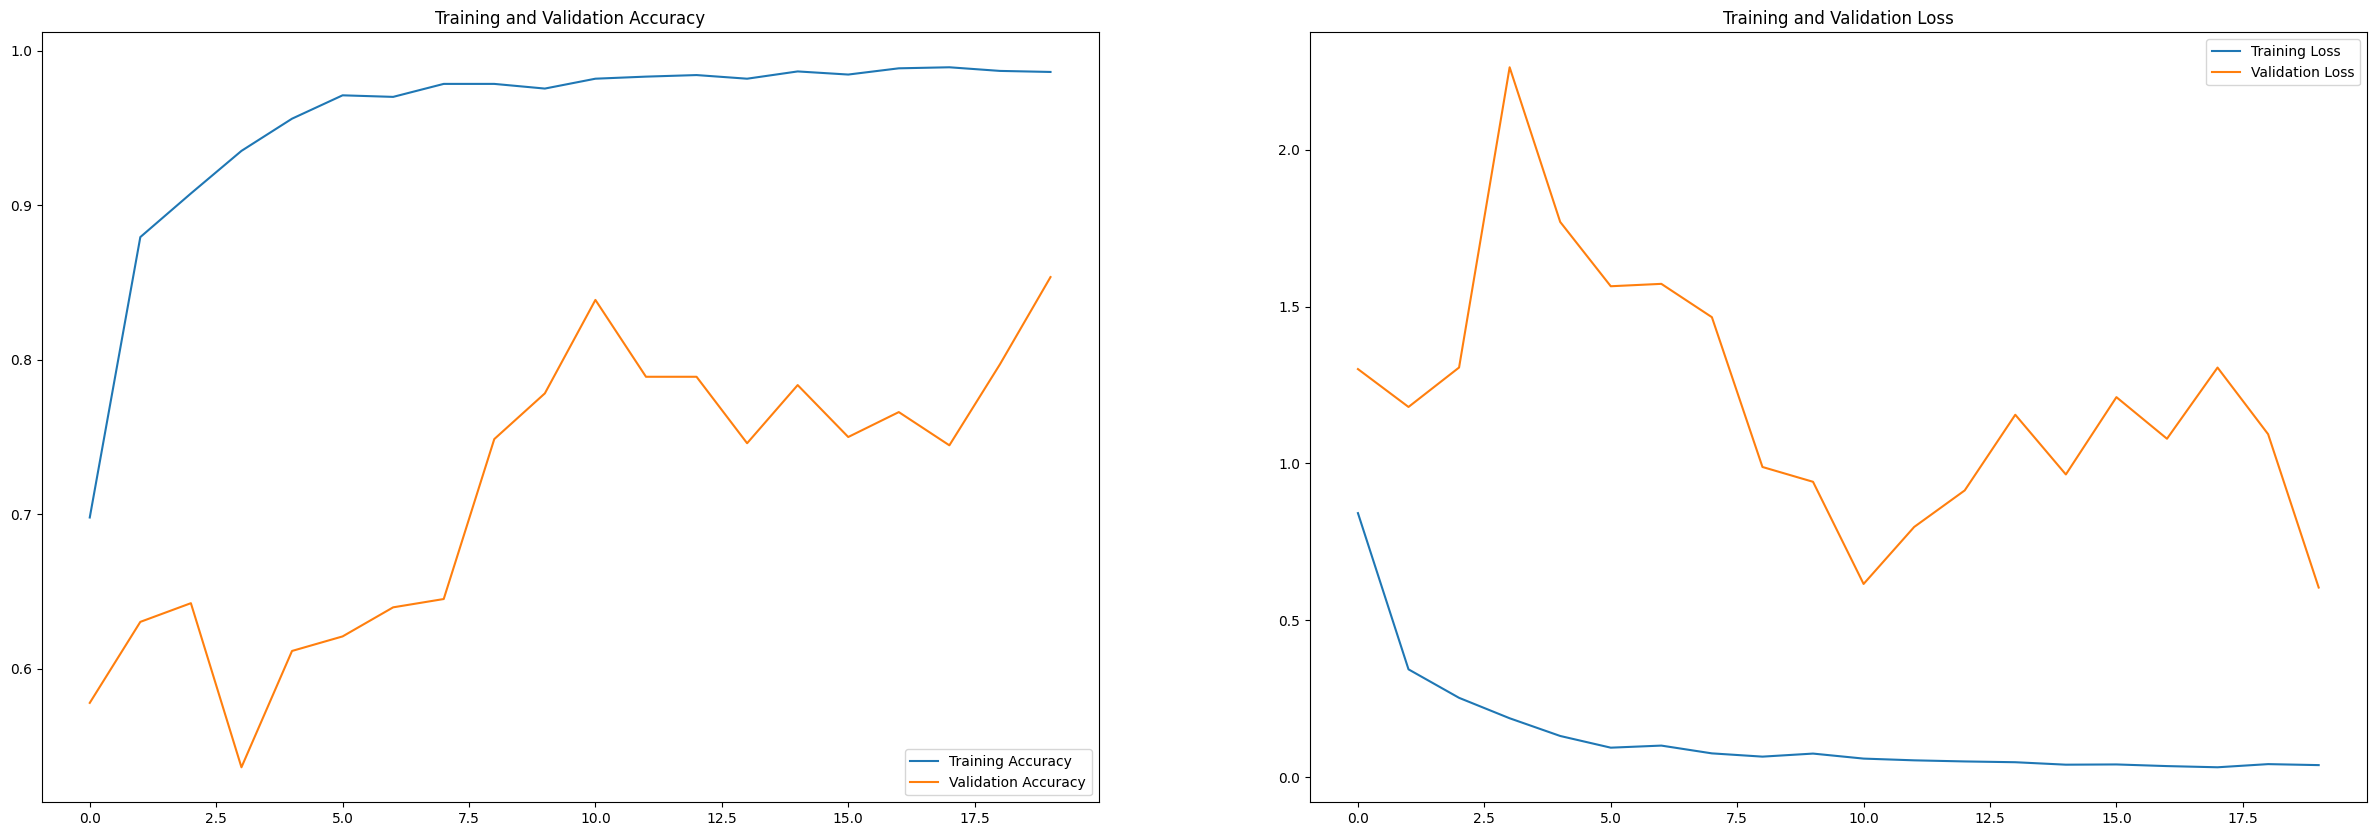

In [11]:
# 학습 결과 시각화
acc = history.history['accuracy']  # 훈련 정확도 기록
val_acc = history.history['val_accuracy']  # 검증 정확도 기록
loss = history.history['loss']  # 훈련 손실 기록
val_loss = history.history['val_loss']  # 검증 손실 기록

epochs_range = range(EPOCHS)  # epoch 범위 설정

plt.figure(figsize=(30, 10))  # 전체 플롯의 크기 설정
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 서브플롯 설정
plt.plot(epochs_range, acc, label='Training Accuracy')  # 훈련 정확도 그래프 플롯
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # 검증 정확도 그래프 플롯
plt.legend(loc='lower right')  # 범례 위치 설정
plt.title('Training and Validation Accuracy')  # 그래프 제목 설정

plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯 설정
plt.plot(epochs_range, loss, label='Training Loss')  # 훈련 손실 그래프 플롯
plt.plot(epochs_range, val_loss, label='Validation Loss')  # 검증 손실 그래프 플롯
plt.legend(loc='upper right')  # 범례 위치 설정
plt.title('Training and Validation Loss')  # 그래프 제목 설정

plt.show()

### 모델 평가

- 적절한 평가지표를 선택해 모델의 성능을 평가합니다.
- test 데이터셋을 사용해 최종적인 성능을 확인합니다.
- 목표 Accuracy: 93% 이상

In [12]:
# 모델 평가
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"검증 손실: {val_loss}")
print(f"검증 정확도: {val_accuracy}")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

24/24 [==============================] - 3s 129ms/step - loss: 0.6043 - accuracy: 0.8535
검증 손실: 0.604269802570343
검증 정확도: 0.8534946441650391
30/30 [==============================] - 5s 165ms/step - loss: 0.3587 - accuracy: 0.9022
테스트 손실: 0.35873839259147644
테스트 정확도: 0.9021505117416382


30/30 [==============================] - 5s 147ms/step
[[149   1   0   0   3   2]
 [  1 128   4   0   1  21]
 [  3   4 122   0   2  24]
 [  0   1   2 148   1   3]
 [  0   0   0   0 151   4]
 [  0   4   0   1   9 141]]


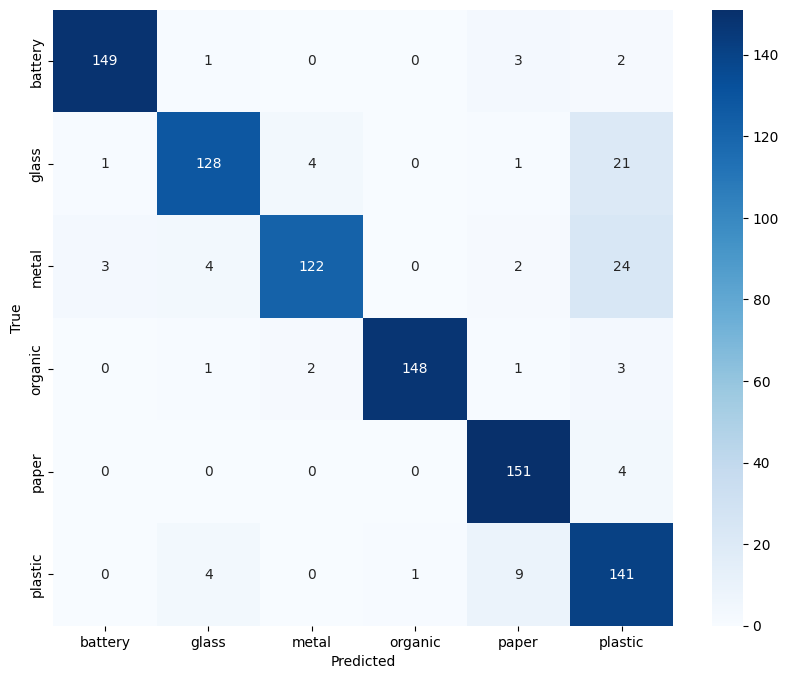

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 예측 결과 가져오기
test_generator.reset()
preds = model.predict(test_generator)
y_preds = np.argmax(preds, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(test_generator.classes, y_preds)
print(cm)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

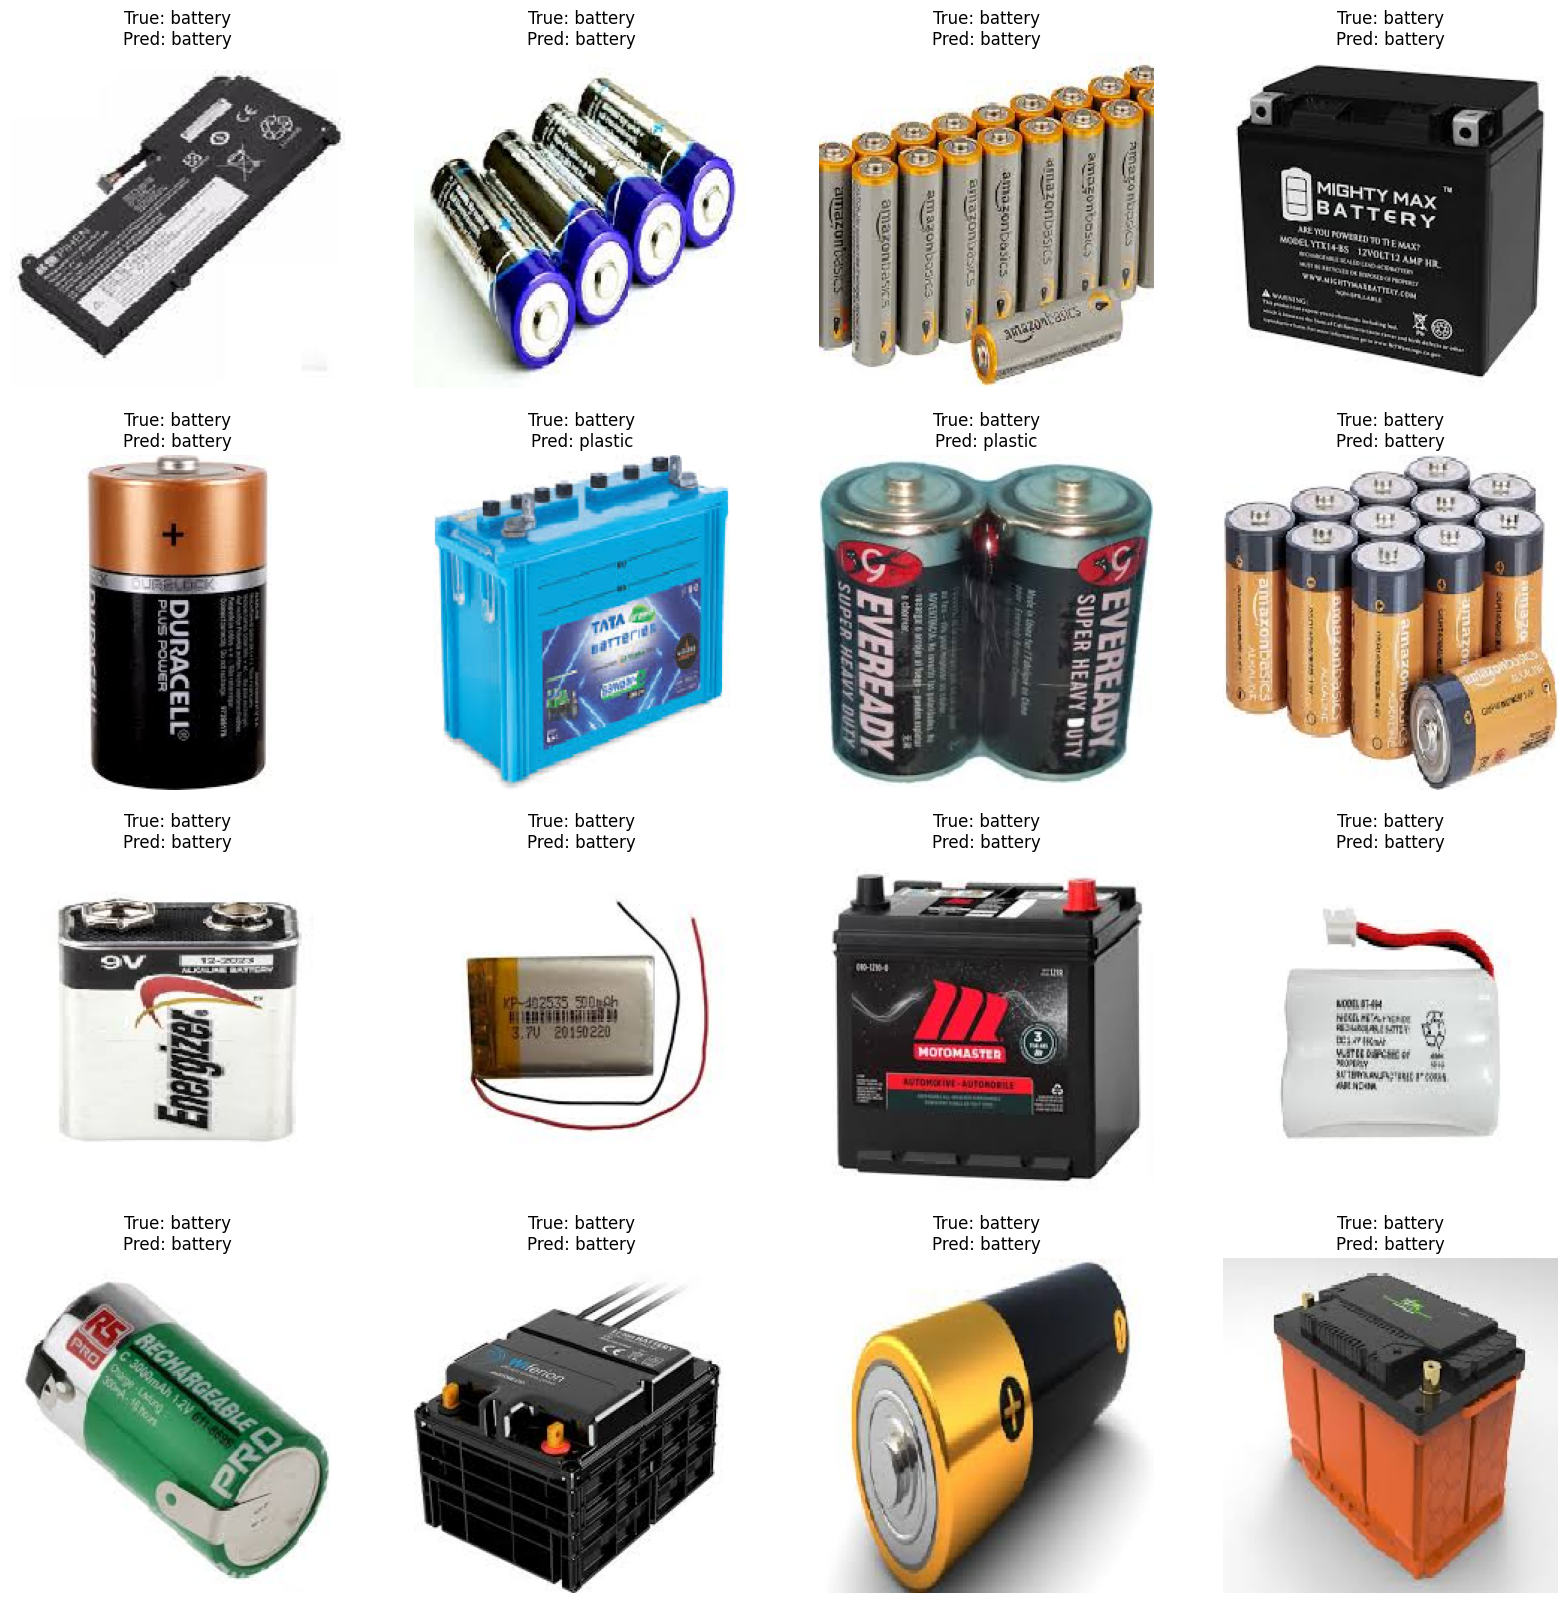

In [14]:
# 예측 결과 시각화
def plot_predictions(images, true_labels, predictions, class_indices):
    class_names = list(class_indices.keys())
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        true_class = class_names[true_labels[i]]
        pred_class = class_names[predictions[i]]
        plt.title(f'True: {true_class}\nPred: {pred_class}')
        plt.axis('off')
    plt.show()

# 테스트 데이터 중 일부를 시각화
test_images, test_labels = next(test_generator)
y_test_labels = np.argmax(test_labels, axis=1)
plot_predictions(test_images[:16], y_test_labels[:16], y_preds[:16], test_generator.class_indices)

### 보너스 과제! 나만의 CNN 모델 구축
- Transfer learning이 아닌 나만의 CNN 구조 만들어 보기
- 기존의 Baseline CNN 구조를 참고해서 직접 레이어들을 쌓아보세요.
- Trnsfer learning 모델의 성능과 비교해 보세요.

In [ ]:
input_layer = tf.keras,layers.Input(shape=(224,224,3))
x = tf.keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
x=tf.keras.layers.Dense(4096, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1000, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])